In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class DataGenerator(nn.Module):
    """
    A simple data generator network that defines a relationship between input x and output y.
    """
    def __init__(self, input_size=1, output_size=100, hidden_sizes=[5], activation='ReLU'):
        super(DataGenerator, self).__init__()
        layers = []
        prev_size = input_size
        act_fn = self.get_activation(activation)

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(act_fn)
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def get_activation(self, activation):
        activations = {
            'ReLU': nn.ReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'LeakyReLU': nn.LeakyReLU()
        }
        return activations.get(activation, nn.ReLU())

    def forward(self, x):
        return self.network(x)


In [ ]:
class GeneratedDataset(Dataset):
    """
    A PyTorch Dataset that uses the DataGenerator to produce data.
    """
    def __init__(self, generator, num_samples=1000):
        super(GeneratedDataset, self).__init__()
        self.generator = generator
        self.num_samples = num_samples
        # Generate input data
        self.x = torch.linspace(-10, 10, steps=num_samples).unsqueeze(1)  # (num_samples, 1)
        # Generate output data
        with torch.no_grad():
            self.y = self.generator(self.x)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
class MLP(nn.Module):
    """
    A MLP for regression tasks.
    """
    def __init__(self, input_size=1, output_size=1, hidden_sizes=[50], activation='ReLU'):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        act_fn = self.get_activation(activation)

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(act_fn)
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        self.network = nn.Sequential(*layers)

    def get_activation(self, activation):
        activations = {
            'ReLU': nn.ReLU(),
            'Sigmoid': nn.Sigmoid(),
            'Tanh': nn.Tanh(),
            'LeakyReLU': nn.LeakyReLU()
        }
        return activations.get(activation, nn.ReLU())

    def forward(self, x):
        return self.network(x)


In [ ]:

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [ ]:

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [ ]:
def plot_losses(train_losses, val_losses, config):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Training and Validation Losses\nConfig: Hidden Layers={config['hidden_sizes']}, Activation={config['activation']}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Using device: cuda

Training MLP with config: Hidden Sizes=[5, 5, 5, 5], Activation=Tanh, LR=0.001
Epoch [1/100] - Train Loss: 0.1088, Val Loss: 0.0271
Epoch [20/100] - Train Loss: 0.0002, Val Loss: 0.0002
Epoch [40/100] - Train Loss: 0.0001, Val Loss: 0.0001
Epoch [60/100] - Train Loss: 0.0000, Val Loss: 0.0000
Epoch [80/100] - Train Loss: 0.0000, Val Loss: 0.0000
Epoch [100/100] - Train Loss: 0.0000, Val Loss: 0.0000


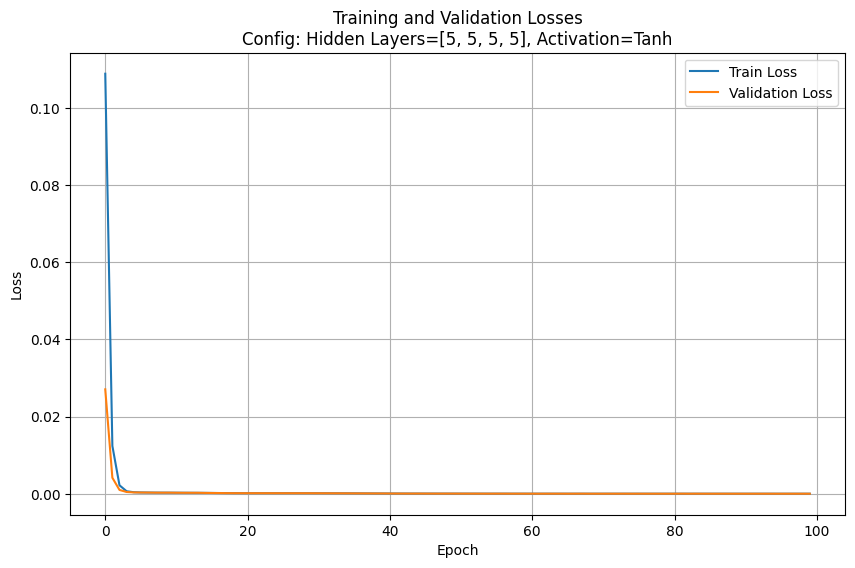

The model has converged (validation loss decreased).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

data_input_size = 1
data_output_size = 100
data_hidden_sizes = [5, 5, 5]
data_activation = 'ReLU'
num_samples = 10000

data_generator = DataGenerator(input_size=data_input_size,
                                output_size=data_output_size,
                                hidden_sizes=data_hidden_sizes,
                                activation=data_activation)

dataset = GeneratedDataset(generator=data_generator, num_samples=num_samples)
X = dataset.x.numpy()
Y = dataset.y.numpy()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                                torch.tensor(Y_train, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                              torch.tensor(Y_val, dtype=torch.float32))
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

configurations = [
    # {'hidden_sizes': [10], 'activation': 'ReLU', 'learning_rate': 0.01},
    {'hidden_sizes': [5, 5, 5, 5], 'activation': 'Tanh', 'learning_rate': 0.001},
    # {'hidden_sizes': [100, 100, 100], 'activation': 'Sigmoid', 'learning_rate': 0.005},
    # {'hidden_sizes': [20, 20], 'activation': 'LeakyReLU', 'learning_rate': 0.01},
]

num_epochs = 100

for config in configurations:
    print(f"\nTraining MLP with config: Hidden Sizes={config['hidden_sizes']}, Activation={config['activation']}, LR={config['learning_rate']}")

    mlp = MLP(input_size=data_input_size,
              output_size=data_output_size,
              hidden_sizes=config['hidden_sizes'],
              activation=config['activation']).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(mlp.parameters(), lr=config['learning_rate'])

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train(mlp, train_loader, criterion, optimizer, device)
        val_loss = validate(mlp, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if (epoch+1) % 20 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    plot_losses(train_losses, val_losses, config)

    if val_losses[-1] < val_losses[0]:
        print("The model has converged (validation loss decreased).")
    else:
        print("The model did not converge (validation loss did not decrease).")


In [ ]:
print("Statistics of y:")
print(f"Mean: {dataset.y.mean().item()}")
print(f"Std Dev: {dataset.y.std().item()}")
print(f"Min: {dataset.y.min().item()}")
print(f"Max: {dataset.y.max().item()}")


Statistics of y:
Mean: 0.02905740588903427
Std Dev: 0.3746444582939148
Min: -1.4558900594711304
Max: 1.8567230701446533
